In [1]:
import gc
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]="2"
# imagenet class2labels: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [2]:
from barcodes import calc_embed_dist, h1sum

def rtd(cl1, cl2):
    return (h1sum(calc_embed_dist(cl1, cl2, pdist_device = 'cpu')) +\
            h1sum(calc_embed_dist(cl2, cl1, pdist_device = 'cpu'))) / 2

In [3]:
import torch
from pytorch_pretrained_gans import make_gan

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type = 'biggan')  # -> nn.Module

Loading BigGAN model biggan-deep-256 from cache at /root/.pytorch_pretrained_biggan/e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


In [4]:
#y = G.sample_class(batch_size=1)  # -> torch.Size([1, 1000])
batch = 100

y = torch.zeros((batch, 1000))
y[:, 248] = 1
z = G.sample_latent(batch_size=batch)  # -> torch.Size([1, 128])
#z += torch.tensor(np.random.normal(0, 0.5, z.shape), dtype = torch.float)
x, all_z = G(z=z, y=y)  # -> torch.Size([1, 3, 256, 256])

/home/anaconda/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


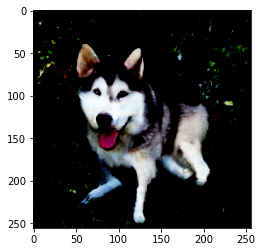

In [5]:
from matplotlib import pyplot as plt

plt.imshow(x.detach()[7,:].permute(1, 2, 0))

In [65]:
import pickle
#latent_z_fixed = z
#pickle.dump(latent_z_fixed, open('z.pickle', 'wb'))
latent_z_fixed = pickle.load(open('z.pickle', 'rb'))

In [67]:
len(latent_z_fixed)

100

In [8]:
all_z_pc = []

for idx, elem in enumerate(all_z):
    if idx % 2 == 0:
        all_z_pc.append(elem.detach().numpy())

In [9]:
for idx, elem in enumerate(all_z_pc):
    print(idx, elem.shape)

0 (100, 256)
1 (100, 32768)
2 (100, 131072)
3 (100, 262144)
4 (100, 1048576)
5 (100, 2097152)
6 (100, 4194304)
7 (100, 8388608)


In [13]:
rtd_matrix = np.zeros((len(all_z_pc), len(all_z_pc)))

for i in range(len(all_z_pc)):
    for j in range(len(all_z_pc)):
        rtd_matrix[i, j] = rtd(all_z_pc[i], all_z_pc[j])
        
        print(i, j)

0 0
0 1
0 2
0 3
0 4
0 5
0 6


RuntimeError: CUDA out of memory. Tried to allocate 6.25 GiB (GPU 0; 23.65 GiB total capacity; 13.19 GiB already allocated; 2.40 GiB free; 13.19 GiB reserved in total by PyTorch)

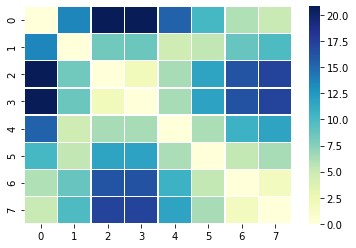

In [17]:
import numpy as np;
import seaborn as sns;
ax = sns.heatmap(rtd_matrix, linewidths=.5, cmap="YlGnBu")

In [10]:
from cka import cka

cka_matrix = np.zeros((len(all_z_pc), len(all_z_pc)))

for i in range(len(all_z_pc)):
    for j in range(len(all_z_pc)):
        cka_matrix[i, j] = cka(torch.tensor(all_z_pc[i], dtype = torch.double),\
                               torch.tensor(all_z_pc[j], dtype = torch.double))

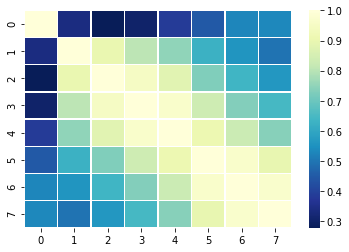

In [11]:
import numpy as np;
import seaborn as sns;
ax = sns.heatmap(cka_matrix, linewidths=.5, cmap="YlGnBu_r")

In [12]:
import numpy as np
import gc

In [14]:
noises = np.arange(0, 0.525, 0.025)
imgs = []
layers = []

global_noise_idx = 1
noises = [noises[0], noises[global_noise_idx]]

for idx, s in enumerate(noises):
    zmod = latent_z_fixed + torch.tensor(np.random.normal(0, s, latent_z_fixed.shape), dtype = torch.float)
    
    img, all_z = G(z = zmod, y = y)  # -> torch.Size([1, 3, 256, 256])
    
    imgs.append(img)
    #layers.append([x.reshape(x.shape[0], -1) for x in all_z])
    layers.append(all_z)
    gc.collect()

In [15]:
import os
from PIL import Image

def write_dir(adir, cloud):
    os.system('rm -rf %s' % adir)
    os.mkdir(adir)
    
    for num in range(cloud.shape[0]):
        data = cloud[num].detach().numpy()
        data = np.uint8((data + 1) / 2 * 255)
        data = np.transpose(data, (1, 2, 0))

        png_data = Image.fromarray(data, mode = 'RGB')
        path = '%s/%d.png' % (adir, num)
        png_data.save(path)

In [30]:
import subprocess

if os.path.isfile('fids.pickle'):
    fids = pickle.load(open('fids.pickle', 'rb'))
else:
    fids = {}

#for idx, k in enumerate(range(1, len(noises))):
write_dir('tmp1', imgs[0])
write_dir('tmp2', imgs[-1])

cmd = 'pytorch-fid tmp1 tmp2 --device cpu'
res_str = subprocess.run(cmd.split(' '), capture_output = True, text = True).stdout

fids[global_noise_idx] = eval(res_str.replace('FID:', ''))

pickle.dump(fids, open('fids.pickle', 'wb'))
print(fids)

{1: 7.6686343267084}


In [ ]:
if os.path.isfile('rtds.pickle'):
    rtds = pickle.load(open('rtds.pickle', 'rb'))
else:
    rtds = {}

#for noise_id, s in enumerate(noises):
for noise_id in [global_noise_idx]:
    for lay_num in range(len(layers[0])):
        rtd_value = rtd(layers[0][lay_num], layers[noise_id][lay_num])
        
        rtds.setdefault(lay_num, {})
        rtds[lay_num][noise_id] = rtd_value
        
        print(noise_id, lay_num, rtd_value)
        
pickle.dump(rtds, open('rtds.pickle', 'wb'))
print(rtds)

1 0 0.5334148108959198
1 1 0.5524145364761353
1 2 0.9675388336181641
1 3 1.1362451910972595
1 4 1.4220870435237885
1 5 1.6152501851320267
1 6 1.912962257862091
1 7 1.8913478553295135
1 8 1.8300607949495316
1 9 1.5422117114067078
1 10 1.4706960171461105
1 11 1.3831380903720856
1 12 1.1237042248249054


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



In [6]:
from cka import cka

In [19]:
cka(torch.tensor(all_z_pc[0], dtype = torch.double), torch.tensor(all_z_pc[1], dtype = torch.double))

/home/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


0.9860216293784749

In [30]:
noises = [pow(2, x/2) / pow(2, 10) for x in range(21)]

In [49]:
len(noises[:-3])

18

In [50]:
len(fids)

20

In [16]:
import pickle
fids = pickle.load(open('fids.pickle', 'rb'))
rtds = pickle.load(open('rtds.pickle', 'rb'))
ckas = pickle.load(open('ckas.pickle', 'rb'))

In [17]:
fids

{1: 0.4087260299142059,
 2: 0.5503868456372274,
 3: 1.0619615122780743,
 4: 1.6526513491258612,
 5: 2.2575287571820297,
 6: 3.0599724818438006,
 7: 4.16292742646732,
 8: 5.361620127262299,
 9: 6.81314017311734,
 10: 8.512811220097582,
 11: 10.586354127103064,
 12: 12.025032748782401,
 13: 13.166831219434947,
 14: 14.717340955802882,
 15: 15.946758943753288,
 16: 16.871075703043154,
 17: 24.64513690841663,
 18: 52.98328990574321,
 19: 175.18440606889087,
 20: 338.17756515807656}

In [18]:
rtds

{0: {1: 0.02988666296005249,
  2: 0.04447358846664429,
  3: 0.06968605518341064,
  4: 0.08935528993606567,
  5: 0.13028815388679504,
  6: 0.17521816492080688,
  7: 0.22027474641799927,
  8: 0.32312676310539246,
  9: 0.48139798641204834,
  10: 0.664146900177002,
  11: 0.8315040469169617,
  12: 1.1736262142658234,
  13: 1.5404459834098816,
  14: 2.0425053238868713,
  15: 2.345494657754898,
  16: 2.9522275030612946,
  17: 3.231891691684723,
  18: 3.6333019733428955,
  19: 3.5330834686756134,
  20: 4.054535448551178},
 2: {1: 0.057826608419418335,
  2: 0.08483603596687317,
  3: 0.12452870607376099,
  4: 0.1845475435256958,
  5: 0.2361024022102356,
  6: 0.3189493268728256,
  7: 0.4462960660457611,
  8: 0.5657183825969696,
  9: 0.8387791365385056,
  10: 1.2846146523952484,
  11: 1.7024838328361511,
  12: 1.890862986445427,
  13: 2.4484077394008636,
  14: 3.294072389602661,
  15: 3.9593930393457413,
  16: 4.806077301502228,
  17: 6.084920823574066,
  18: 7.468714416027069,
  19: 7.50148622691

In [19]:
ckas

{0: {1: 0.9999932881785316,
  2: 0.999986047656042,
  3: 0.9999727213853113,
  4: 0.9999462966885942,
  5: 0.9998916585602234,
  6: 0.9997798310314655,
  7: 0.999576387530611,
  8: 0.9991375150597586,
  9: 0.998237271051535,
  10: 0.9965585903728362,
  11: 0.9931854846410628,
  12: 0.9859460206836403,
  13: 0.9743655534455573,
  14: 0.9506744036907954,
  15: 0.907777308010036,
  16: 0.8496920125754432,
  17: 0.7745777841253519,
  18: 0.7059709858441967,
  19: 0.6538828758325559,
  20: 0.5939891806104123},
 2: {1: 0.9999853791313082,
  2: 0.9999748388427099,
  3: 0.999943978181095,
  4: 0.9998717232046059,
  5: 0.9997698334788361,
  6: 0.9996184361997809,
  7: 0.9991421269216909,
  8: 0.9983164113655923,
  9: 0.9966507630612865,
  10: 0.9932202615379961,
  11: 0.986102828785162,
  12: 0.9698662563074629,
  13: 0.943206646332502,
  14: 0.922913632757579,
  15: 0.8012358829938172,
  16: 0.6789278147443859,
  17: 0.4948812693343071,
  18: 0.3470874884398424,
  19: 0.19964920511287457,
  20

In [80]:
for lay in [0, 2, 4, 6, 8, 10, 12]:
    f = [x[1] for x in sorted(fids.items())][:-4]
    r = [x[1] for x in sorted(rtds[lay].items())][:-4]
    c = [1 - x[1] for x in sorted(ckas[lay].items())][:-4]
    
    import numpy as np
    print(np.corrcoef(f, r)[0,1], np.corrcoef(f, c)[0,1])

0.9467775094359611 0.7620231903696076
0.9547364612202763 0.7446260117379889
0.9650370212085005 0.7632917845652237
0.9639944425658084 0.7772904121717974
0.9702346670029217 0.7932531191706015
0.965049011160688 0.7970610694844313
0.9700926004375747 0.7956953752002346


In [81]:
from matplotlib import pyplot as plt

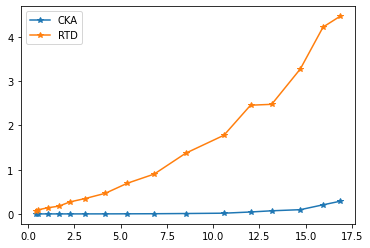

In [82]:
plt.plot(f, c, '*-', label = 'CKA')
plt.plot(f, r, '*-', label = 'RTD')
plt.legend()

In [83]:
import numpy as np
np.corrcoef(f, r)[0,1]

0.9700926004375747

In [84]:
import numpy as np
np.corrcoef(f, c)[0,1]

0.7956953752002346

In [86]:
from sklearn.preprocessing import MinMaxScaler

In [88]:
scaler = MinMaxScaler()

In [90]:
from copy import copy

f_orig = copy(f)
c_orig = copy(c)
r_orig = copy(r)

In [91]:
f = np.array(f)
f = f[..., np.newaxis]
f = scaler.fit_transform(f)

r = np.array(r)
r = r[..., np.newaxis]
r = scaler.fit_transform(r)

c = np.array(c)
c = c[..., np.newaxis]
c = scaler.fit_transform(c)

In [92]:
len(noises), noises

(21,
 [0.0009765625,
  0.0013810679320049757,
  0.001953125,
  0.0027621358640099515,
  0.00390625,
  0.005524271728019903,
  0.0078125,
  0.011048543456039806,
  0.015625,
  0.02209708691207961,
  0.03125,
  0.04419417382415922,
  0.0625,
  0.08838834764831845,
  0.125,
  0.1767766952966369,
  0.25,
  0.3535533905932738,
  0.5,
  0.7071067811865476,
  1.0])

In [93]:
len(c), len(f)

(16, 16)

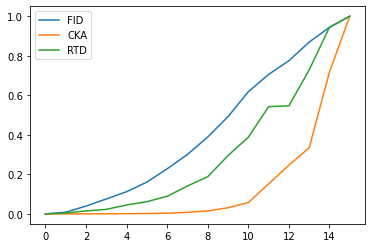

In [94]:
plt.plot(f, label = 'FID')
plt.plot(c, label = 'CKA')
plt.plot(r, label = 'RTD')
plt.legend()

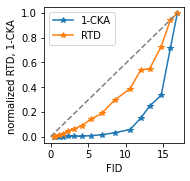

In [113]:
fig, ax = plt.subplots(1, 1)

fig.set_size_inches((2.5, 2.5))

plt.plot(f_orig, c, '*-', label = '1-CKA')
plt.plot(f_orig, r, '*-', label = 'RTD')
plt.plot(np.arange(0, 1.1, 0.1) * f_orig[-1], np.arange(0, 1.1, 0.1), label = '', linestyle = '--', color = 'grey')
ax.set_xlabel('FID')
ax.set_ylabel('normalized RTD, 1-CKA ')
#plt.title('RTD')
plt.legend()

In [35]:
noises[:-4]

[0.0009765625,
 0.0013810679320049757,
 0.001953125,
 0.0027621358640099515,
 0.00390625,
 0.005524271728019903,
 0.0078125,
 0.011048543456039806,
 0.015625,
 0.02209708691207961,
 0.03125,
 0.04419417382415922,
 0.0625,
 0.08838834764831845,
 0.125,
 0.1767766952966369,
 0.25]